In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format, year, datediff, current_date
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint
import pandas as pd
from math import sqrt

sc = SparkContext("local", "MyApp")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/23 12:30:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
'''
Criando um SparkSession para trabalhar com spark df
Criando um SparkContext local para trabalhar com RDDs
'''
spark = SparkSession.builder.getOrCreate()

In [4]:
#sc = SparkContext.getOrCreate()

#nome_spark_context = sc.appName

#print("Nome do SparkContext:", nome_spark_context)

In [5]:
print("The version of Spark Context in the PySpark shell is", sc.version)
print("The Python version of Spark Context in the PySpark shell is", sc.pythonVer)
print("The master of Spark Context in the PySpark shell is", sc.master)

The version of Spark Context in the PySpark shell is 3.3.1
The Python version of Spark Context in the PySpark shell is 3.8
The master of Spark Context in the PySpark shell is local


In [6]:
fifa_file_path = "./datasets/Fifa2018_dataset.csv"
shakespeare_file_path = "./datasets/Complete_Shakespeare.txt"
people_file_path = "./datasets/people.csv"
ratings_file_path = "./datasets/ratings.csv"
spam_file_path = "./datasets/spam.txt"
non_spam_file_path = "./datasets/ham.txt"
points_file_path = "./datasets/5000_points.txt"
file_path = "./datasets/README.txt"

In [7]:
'''
método parallelize para distribuir a sequência de números contidos em numb em um cluster Spark RDD
método collect  coleta os dados distribuídos em spark_data e os reune em uma lista local
'''
numb_range_one = range(1, 100)
spark_data = sc.parallelize(numb_range_one)
print(spark_data)
result_spark_data = spark_data.collect()
print(result_spark_data)

PythonRDD[1] at RDD at PythonRDD.scala:53
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [8]:
'''
Criando um RDD a partir de um arquivo texto
'''
fileRDD = sc.textFile(file_path)
collected_data = fileRDD.collect()
for line in collected_data:
    print(line)

[![buildstatus](https://travis-ci.org/holdenk/learning-spark-examples.svg?branch=master)](https://travis-ci.org/holdenk/learning-spark-examples)
Examples for Learning Spark
Examples for the Learning Spark book. These examples require a number of libraries and as such have long build files. We have also added a stand alone example with minimal dependencies and a small build file
in the mini-complete-example directory.


These examples have been updated to run against Spark 1.3 so they may
be slightly different than the versions in your copy of "Learning Spark".

Requirements
==
* JDK 1.7 or higher
* Scala 2.10.3
- scala-lang.org
* Spark 1.3
* Protobuf compiler
- On debian you can install with sudo apt-get install protobuf-compiler
* R & the CRAN package Imap are required for the ChapterSixExample
* The Python examples require urllib3

Python examples
===

From spark just run ./bin/pyspark ./src/python/[example]

Spark Submit
===

You can also create an assembly jar with all of the depen

In [9]:
'''
função map é utilizada para serem feitas alterações no vetor, elemento por elemento sem utilizar um laço for
função lambda é uma forma reduzida de se declarar uma função em python
'''
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print("Input list is", my_list)

squared_list_lambda = list(map(lambda x: x**2, my_list))
print("The squared numbers are", squared_list_lambda)

Input list is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The squared numbers are [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


In [10]:
'''
função filter percorre todo o vetor elemento por elemento e só retorna os valores que forem TRUE do filtro
'''
my_list_2 = [10, 21, 31, 40, 51, 60, 72, 80, 93, 101]
print("Input list is:", my_list_2)

filtered_list = list(filter(lambda x: (x%10 == 0), my_list_2))
print("Numbers divisible by 10 are:", filtered_list)

Input list is: [10, 21, 31, 40, 51, 60, 72, 80, 93, 101]
Numbers divisible by 10 are: [10, 40, 60, 80]


In [11]:
RDD = sc.parallelize(["Spark", "is", "a", "framework", "for", "Big Data processing"])
print("The type of RDD is", type(RDD))
RDD_collect = RDD.collect()
print(RDD_collect)

The type of RDD is <class 'pyspark.rdd.RDD'>
['Spark', 'is', 'a', 'framework', 'for', 'Big Data processing']


In [12]:
print("The file_path is", file_path)

print("The file type of fileRDD is", type(fileRDD))

The file_path is ./datasets/README.txt
The file type of fileRDD is <class 'pyspark.rdd.RDD'>


In [13]:
'''
Partições são unidades de distribuição dos dados em um RDD, as partições influenciam como os dados são distribuídos e processados
O RDD será dividido em pelo menos 5 partições o que ajuda a distribuir o processamento de dados de maneira mais eficiente
Mais partições podem permitir um melhor paralelismo
'''
print("Number of partitions in fileRDD is", fileRDD.getNumPartitions())

fileRDD_part = sc.textFile(file_path, minPartitions = 5)

print("Number of partitions in fileRDD_part is", fileRDD_part.getNumPartitions())

Number of partitions in fileRDD is 1
Number of partitions in fileRDD_part is 5


In [14]:
'''
Aplicando a função map em um RDD e criando um novo RDD cubedRDD
'''
numb_range_two = range(1, 11)
numbRDD = sc.parallelize(numb_range_two)
cubedRDD = numbRDD.map(lambda x: x**3)

numbers_all = cubedRDD.collect()
print(numbers_all)

[1, 8, 27, 64, 125, 216, 343, 512, 729, 1000]


In [15]:
'''
Utilizando a função filter em um RDD
Verificando o total de linhas com o método count()
Imprimindo as 4 primeiras linhas com o método take()
'''
fileRDD_filter = fileRDD.filter(lambda line: 'Spark' in line)

print("The total number of lines with the keyword Spark is", fileRDD_filter.count())

print(fileRDD_filter.take(4))

The total number of lines with the keyword Spark is 7
['Examples for Learning Spark', 'Examples for the Learning Spark book. These examples require a number of libraries and as such have long build files. We have also added a stand alone example with minimal dependencies and a small build file', 'These examples have been updated to run against Spark 1.3 so they may', 'be slightly different than the versions in your copy of "Learning Spark".']


In [16]:
'''
Criando uma lista de pares (chave, valor)
Método reduceByKey usado para mesclar os valores com base na chave
'''
pairRDD = sc.parallelize([(1,2), (3,4), (3,6), (4,5)])

rdd_reduced = pairRDD.reduceByKey(lambda x, y: x+y)
print(rdd_reduced.collect(), "\n")

for num in rdd_reduced.collect(): 
  print(f"Key {num[0]} has {num[1]} Counts")

[(1, 2), (3, 10), (4, 5)] 

Key 1 has 2 Counts
Key 3 has 10 Counts
Key 4 has 5 Counts


In [17]:
'''
Utilizando o método sortByKey para ordenar a lista de pares já mesclada em ordem decrescente
'''
rdd_reduced_sort = rdd_reduced.sortByKey(ascending=False)

print(rdd_reduced_sort.collect(), "\n")

for num in rdd_reduced_sort.collect():
  print(f"Key {num[0]} has {num[1]} Counts")

[(4, 5), (3, 10), (1, 2)] 

Key 4 has 5 Counts
Key 3 has 10 Counts
Key 1 has 2 Counts


In [18]:
'''
countByKey utilizado para fazer uma contagem de quantas vezes a chave aparece na lista e gera um defaultdict
defaultdict é um tipo de dicionário (ou mapa) que é uma estrutura de dados que mapeia chaves para valores
'''
total = pairRDD.countByKey()

print(f"The type of total is {type(total)}\n")
print(f"{total.items()}\n")

for k, v in total.items(): 
  print(f"key {k} has {v} counts")

The type of total is <class 'collections.defaultdict'>

dict_items([(1, 1), (3, 2), (4, 1)])

key 1 has 1 counts
key 3 has 2 counts
key 4 has 1 counts


In [19]:
'''
flatMap divide o elemento em caracteres individuais
map aplica uma função a cada elemento (posição) do RDD, o RDD resultante possui a mesma quantidade de elementos
'''
shakespeareRDD = sc.textFile(shakespeare_file_path)
print(shakespeareRDD.take(5), "\n")

splitRDD = shakespeareRDD.flatMap(lambda x: x.split())
print(splitRDD.take(2), "\n")

splitRDD2 = shakespeareRDD.map(lambda x: x.split())
print(splitRDD2.take(2))

print("Total number of words in splitRDD:", splitRDD.count())

['The Project Gutenberg EBook of The Complete Works of William Shakespeare, by', 'William Shakespeare', '', 'This eBook is for the use of anyone anywhere at no cost and with', 'almost no restrictions whatsoever.  You may copy it, give it away or'] 

['The', 'Project'] 

[['The', 'Project', 'Gutenberg', 'EBook', 'of', 'The', 'Complete', 'Works', 'of', 'William', 'Shakespeare,', 'by'], ['William', 'Shakespeare']]
Total number of words in splitRDD: 128576


In [20]:
'''
Verificando com a função filter palavras que estão na lista que não estejam na lista stop_words e gerando um novo RDD com elas
Criando um RDD de pares (chave, valor) com cada ocorrência da palavra sendo a chave
Mesclando todos os pares com base na chave e fazendo um somatório de suas ocorrências
'''
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 'just', 'don', 'should', 'now']

splitRDD_no_stop = splitRDD.filter(lambda x: x.lower() not in stop_words)
print(splitRDD_no_stop.take(5), "\n")

splitRDD_no_stop_words = splitRDD_no_stop.map(lambda w: (w, 1))
print(splitRDD_no_stop_words.take(30), "\n")

resultRDD_stop_words = splitRDD_no_stop_words.reduceByKey(lambda x, y: x + y)
print(resultRDD_stop_words.take(10))

['Project', 'Gutenberg', 'EBook', 'Complete', 'Works'] 

[('Project', 1), ('Gutenberg', 1), ('EBook', 1), ('Complete', 1), ('Works', 1), ('William', 1), ('Shakespeare,', 1), ('William', 1), ('Shakespeare', 1), ('eBook', 1), ('use', 1), ('anyone', 1), ('anywhere', 1), ('cost', 1), ('almost', 1), ('restrictions', 1), ('whatsoever.', 1), ('may', 1), ('copy', 1), ('it,', 1), ('give', 1), ('away', 1), ('re-use', 1), ('terms', 1), ('Project', 1), ('Gutenberg', 1), ('License', 1), ('included', 1), ('eBook', 1), ('online', 1)] 

[('Project', 9), ('Gutenberg', 7), ('EBook', 1), ('Complete', 3), ('Works', 3), ('William', 11), ('Shakespeare,', 1), ('Shakespeare', 12), ('eBook', 2), ('use', 38)]


In [21]:
'''
Trocando a ordem da chave, valor e inserindo em um novo RDD
Fazendo uma ordenação descrecente pela chave (quantidade de ocorrências), dessa forma encontrando as mais utilizadas
'''
resultRDD_swap = resultRDD_stop_words.map(lambda x: (x[1], x[0]))
print(resultRDD_swap.take(7), "\n")

resultRDD_swap_sort = resultRDD_swap.sortByKey(ascending=False)
print(resultRDD_swap_sort.take(7))

[(9, 'Project'), (7, 'Gutenberg'), (1, 'EBook'), (3, 'Complete'), (3, 'Works'), (11, 'William'), (1, 'Shakespeare,')] 

[(650, 'thou'), (574, 'thy'), (393, 'shall'), (311, 'would'), (295, 'good'), (286, 'thee'), (273, 'love')]


In [22]:
'''
Convertendo um RDD do tipo chave, valor em um spark dataFrame 
'''
sample_list = [('Mona', 20), ('Jennifer', 34), ('John', 20), ('Jim', 26)]
sampleRDD = sc.parallelize(sample_list)
print(sampleRDD.collect())

sample_spark_df = spark.createDataFrame(sampleRDD, schema=['Name', 'Age'])
print("The type of names_df is", type(sample_spark_df))
sample_spark_df.show()

[('Mona', 20), ('Jennifer', 34), ('John', 20), ('Jim', 26)]
The type of names_df is <class 'pyspark.sql.dataframe.DataFrame'>
+--------+---+
|    Name|Age|
+--------+---+
|    Mona| 20|
|Jennifer| 34|
|    John| 20|
|     Jim| 26|
+--------+---+



In [23]:
'''
Lendo um arquivo csv e transformando em um spark dataFrame
'''
people_spark_df = spark.read.csv(people_file_path, header=True, inferSchema=True)

print("The type of people_df is", type(people_spark_df))
people_spark_df.show(5)

The type of people_df is <class 'pyspark.sql.dataframe.DataFrame'>
+---+---------+--------------+------+-------------------+
|_c0|person_id|          name|   sex|      date of birth|
+---+---------+--------------+------+-------------------+
|  0|      100|Penelope Lewis|female|1990-08-31 00:00:00|
|  1|      101| David Anthony|  male|1971-10-14 00:00:00|
|  2|      102|     Ida Shipp|female|1962-05-24 00:00:00|
|  3|      103|  Joanna Moore|female|2017-03-10 00:00:00|
|  4|      104|Lisandra Ortiz|female|2020-08-05 00:00:00|
+---+---------+--------------+------+-------------------+
only showing top 5 rows



In [24]:
'''
Utilizando método count para verificar o total de linhas de um df
Método columns para verificar o nome das colunas e len(columns) para verificar a quantidade de colunas
Utilizando printSchema para verificar o tipo de cada coluna
'''
print(f"There are {people_spark_df.count()} rows in the people_spark_df DataFrame.")
print(f"There are {len(people_spark_df.columns)} columns in the people_spark_df DataFrame and their names are {people_spark_df.columns}")

people_spark_df.printSchema()

There are 100000 rows in the people_spark_df DataFrame.
There are 5 columns in the people_spark_df DataFrame and their names are ['_c0', 'person_id', 'name', 'sex', 'date of birth']
root
 |-- _c0: integer (nullable = true)
 |-- person_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- date of birth: timestamp (nullable = true)



In [25]:
'''
Gerando um novo spark df selecionando apenas as colunas 'name', 'sex' e 'date of birth'
Utilizando o método dropDuplicates para retirar linhas duplicadas
'''
people_df_sub = people_spark_df.select('name','sex', 'date of birth')
people_df_sub.show(5)

people_df_sub_nodup = people_df_sub.dropDuplicates()

print(f"There were {people_df_sub.count()} rows before removing duplicates, and {people_df_sub_nodup.count()} rows after removing duplicates")

+--------------+------+-------------------+
|          name|   sex|      date of birth|
+--------------+------+-------------------+
|Penelope Lewis|female|1990-08-31 00:00:00|
| David Anthony|  male|1971-10-14 00:00:00|
|     Ida Shipp|female|1962-05-24 00:00:00|
|  Joanna Moore|female|2017-03-10 00:00:00|
|Lisandra Ortiz|female|2020-08-05 00:00:00|
+--------------+------+-------------------+
only showing top 5 rows

There were 100000 rows before removing duplicates, and 99998 rows after removing duplicates


In [26]:
'''
Filtrando o df apenas pelo sexo female e depois male e gerando dois novos df com os resultados
Realizando uma contagem do número de linhas para saber se possui mais female ou male no df
'''
people_df_female = people_spark_df.filter(people_spark_df.sex == "female")
people_df_female.show(3)

people_df_male = people_spark_df.filter(people_spark_df.sex == "male")
people_df_male.show(3)

print(f"There are {people_df_female.count()} rows in the people_df_female DataFrame and {people_df_male.count()} rows in the people_df_male DataFrame")

+---+---------+--------------+------+-------------------+
|_c0|person_id|          name|   sex|      date of birth|
+---+---------+--------------+------+-------------------+
|  0|      100|Penelope Lewis|female|1990-08-31 00:00:00|
|  2|      102|     Ida Shipp|female|1962-05-24 00:00:00|
|  3|      103|  Joanna Moore|female|2017-03-10 00:00:00|
+---+---------+--------------+------+-------------------+
only showing top 3 rows

+---+---------+-------------+----+-------------------+
|_c0|person_id|         name| sex|      date of birth|
+---+---------+-------------+----+-------------------+
|  1|      101|David Anthony|male|1971-10-14 00:00:00|
|  5|      105|David Simmons|male|1999-12-30 00:00:00|
|  6|      106|Edward Hudson|male|1983-05-09 00:00:00|
+---+---------+-------------+----+-------------------+
only showing top 3 rows

There are 49014 rows in the people_df_female DataFrame and 49066 rows in the people_df_male DataFrame


In [27]:
'''
Criando uma tabela temporária com people para utilizar sql querys em leituras do spark df
'''
people_spark_df.createOrReplaceTempView("people")

select_people_query = '''SELECT name FROM people'''

people_df_names = spark.sql(select_people_query)
people_df_names.show(3)

people_female_df = spark.sql('SELECT * FROM people WHERE sex=="female"')

people_male_df = spark.sql('SELECT * FROM people WHERE sex=="male"')

print("There are {people_female_df.count()} rows in the people_female_df and {people_male_df.count()} rows in the people_male_df DataFrames")

+--------------+
|          name|
+--------------+
|Penelope Lewis|
| David Anthony|
|     Ida Shipp|
+--------------+
only showing top 3 rows

There are {people_female_df.count()} rows in the people_female_df and {people_male_df.count()} rows in the people_male_df DataFrames


In [28]:
'''
Alterando a coluna date of birth para que fique somente no formato data, ano e dia
Criando uma nova coluna no spark df chamada age, onde é convertido a data de nascimento na idade
Selecionando somente as colunas name e age do df e limitando para no máximo 5 elementos
Utilizando o método toPandas para converter o spark df em um pandas df (facilita para criar gráficos)
'''
people_date_format = people_spark_df.withColumn("date of birth", date_format("date of birth", "yyyy-MM-dd"))
people_age = people_date_format.withColumn("age", year(current_date()) - year("date of birth"))
people_age.show(3)

people_name_age_limit5 = people_age.select('name', 'age').limit(5)

people_pandas_name_age_5 = people_name_age_limit5.toPandas()
people_pandas_name_age_5.head()

+---+---------+--------------+------+-------------+---+
|_c0|person_id|          name|   sex|date of birth|age|
+---+---------+--------------+------+-------------+---+
|  0|      100|Penelope Lewis|female|   1990-08-31| 33|
|  1|      101| David Anthony|  male|   1971-10-14| 52|
|  2|      102|     Ida Shipp|female|   1962-05-24| 61|
+---+---------+--------------+------+-------------+---+
only showing top 3 rows



,name,age
0,Penelope Lewis,33
1,David Anthony,52
2,Ida Shipp,61
3,Joanna Moore,6
4,Lisandra Ortiz,3


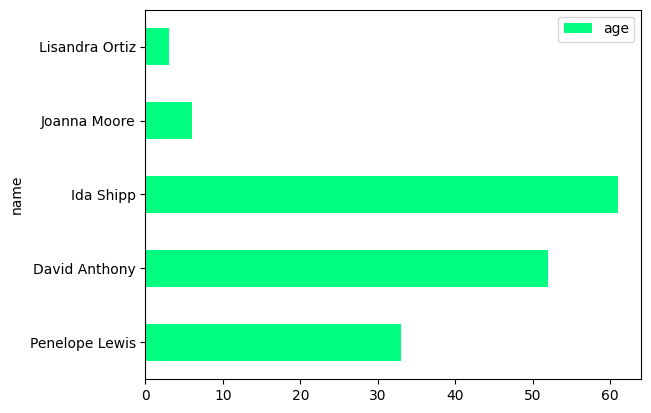

In [29]:
'''
Utilizando o pandas df para gerar um gráfico com a matplotlib.pyplot
'''
people_pandas_name_age_5.plot(kind='barh', x='name', y='age', colormap='winter_r')
plt.show()

In [30]:
fifa_spark_df = spark.read.csv(fifa_file_path, header=True, inferSchema=True)

fifa_spark_df.show(1)

print(f"There are {fifa_spark_df.count()} rows in the fifa_df DataFrame")

23/10/23 12:30:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+---+-----------------+---+--------------------+-----------+--------------------+-------+---------+--------------+--------------------+------+-----+-------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+-------------------+----+----+----+----+----+----+----+----+----+----+----+
|_c0|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|          Club|           C

In [31]:
'''
Criando uma view temporária fifa_df_table para utilizar sql queries
Filtrando somente por nacionalidade Germany e selecionando a idade de todos
Utilizando método describe para exibir as estatísticas do novo spark df
'''
fifa_spark_df.createOrReplaceTempView('fifa_df_table')

fifa_sql_query = '''SELECT Age FROM fifa_df_table WHERE Nationality == "Germany"'''

fifa_germany_age = spark.sql(fifa_sql_query)

fifa_germany_age.show(3)
fifa_germany_age.describe().show()

+---+
|Age|
+---+
| 31|
| 27|
| 28|
+---+
only showing top 3 rows

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|             1140|
|   mean|24.20263157894737|
| stddev|4.197096712293756|
|    min|               16|
|    max|               36|
+-------+-----------------+



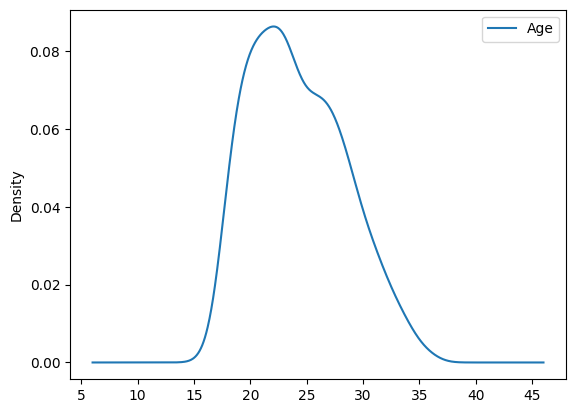

In [32]:
'''
Após o tratamento dos dados com spark, utilizando novamente a conversão toPandas para facilitar a criação de gráficos
Plotando um gráfico de densidade, ele representa a ocorrência por idade dos jogadores de Germany
'''
fifa_df_germany_age_pandas = fifa_germany_age.toPandas()

fifa_df_germany_age_pandas.plot(kind='density')
plt.show()

In [33]:
'''
Lendo arquivo texto ratings e gerando um RDD
Utilizando a função map para separar os elementos por ',' e gerar um novo RDD com listas de valores
Classe Rating para criar objetos de avaliação com três atributos: user, product e rating
Utilizando o objeto Rating para treinar modelos, dividindo em training e test
Conjunto de treinamento utilizado para aprender os padrões em relação entre os usuários e os produtos com base nas avaliações
Conjunto de teste será utilizado para testar o desempenho do modelo treinado
'''
ratingsRDD = sc.textFile(ratings_file_path)
print(ratingsRDD.take(3), "\n")

ratings = ratingsRDD.map(lambda l: l.split(','))
print(ratings.take(3))

ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))
print(ratings_final.take(3))

training_ratings, test_ratings = ratings_final.randomSplit([0.8, 0.2])
print(training_ratings.take(3))
print(test_ratings.take(3))

['1,31,2.5,1260759144', '1,1029,3.0,1260759179', '1,1061,3.0,1260759182'] 

[['1', '31', '2.5', '1260759144'], ['1', '1029', '3.0', '1260759179'], ['1', '1061', '3.0', '1260759182']]


[Rating(user=1, product=31, rating=2.5), Rating(user=1, product=1029, rating=3.0), Rating(user=1, product=1061, rating=3.0)]


[Rating(user=1, product=31, rating=2.5), Rating(user=1, product=1029, rating=3.0), Rating(user=1, product=1061, rating=3.0)]
[Rating(user=1, product=1263, rating=2.0), Rating(user=1, product=1287, rating=2.0), Rating(user=2, product=225, rating=3.0)]


In [34]:
'''
Utilizando o algoritmo ALS para treinar um modelo com base no conjunto de treinamento
Função map para extrair apenas o user e o product sem as avaliações feitas a partir do conjunto de teste
Método predictAll do nosso modelo treinado para prever as avaliações do conjunto teste extraído
'''
model_ratings = ALS.train(training_ratings, rank=10, iterations=10)

testdata_no_rating = test_ratings.map(lambda p: (p[0], p[1]))

predictions = model_ratings.predictAll(testdata_no_rating)

predictions.take(3)

[Rating(user=70, product=667, rating=0.8935661331368543),
 Rating(user=551, product=667, rating=0.8226495302272643),
 Rating(user=628, product=5618, rating=4.2188325521671075)]

In [35]:
'''
Transformando os objetos de avaliação Rating em um novo RDD rates separando em um par de chaves (user, product) e o valor rating
Separando as previsões da mesma forma, um par de chaves (user, product) e o valor são as previsões do modelo
Método join para unir os RDDs rates e preds com base nas chaves, deixando lado a lado as avaliações reais e a previsões do modelo
MSE para calcular o erro métrico quadrático e avaliar o desempenho do modelo
'''
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))
print(rates.take(3))

preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))
print(preds.take(3))

rates_and_preds = rates.join(preds)
print(rates_and_preds.take(3))

MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

[((1, 31), 2.5), ((1, 1029), 3.0), ((1, 1061), 3.0)]


[((70, 667), 0.8935661331368543), ((551, 667), 0.8226495302272643), ((628, 5618), 4.2188325521671075)]


[((1, 1263), (2.0, 1.4999480130600746)), ((1, 1287), (2.0, 3.030346982497214)), ((2, 266), (5.0, 3.666408157173989))]
Mean Squared Error of the model for the test data = 1.33


In [36]:
'''
Lendo dois arquivos textos e gerando dois RDDs
Separando cada um deles com o método split em uma função flatMap apenas por espaços vazios
Imprimindo a primeira palavra que aparece em ambos já separados
'''
spam_rdd = sc.textFile(spam_file_path)
non_spam_rdd = sc.textFile(non_spam_file_path)

spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


In [37]:
'''
Criando uma instância HashingTF para converter uma sequência de palavras em um vetor de características definido como 200
Aplicando transform em ambos os RDDs convertendo cada palavra em um vetor de características de tamanho 200
Transformando em um objeto LabeledPoint e definindo o rótulo 1 para spam e 0 para non_spam
Juntando ambos os RDDs usando o método union com base nos Labels
'''
tf = HashingTF(numFeatures=200)

spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

print(spam_features.take(2))
print(non_spam_features.take(2))

spam_samples = spam_features.map(lambda features:LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features:LabeledPoint(0, features))

print(spam_samples.take(2))
print(non_spam_samples.take(2))

samples = spam_samples.union(non_spam_samples)
count_samples = samples.map(lambda x: (x.label, x.features)).countByKey()

print(samples.take(2))
print(count_samples)

[SparseVector(200, {103: 1.0, 111: 1.0, 119: 1.0}), SparseVector(200, {14: 1.0, 89: 1.0, 193: 1.0, 199: 1.0})]


[SparseVector(200, {103: 2.0, 136: 1.0, 162: 2.0}), SparseVector(200, {64: 1.0, 163: 2.0})]


[LabeledPoint(1.0, (200,[103,111,119],[1.0,1.0,1.0])), LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0]))]


[LabeledPoint(0.0, (200,[103,136,162],[2.0,1.0,2.0])), LabeledPoint(0.0, (200,[64,163],[1.0,2.0]))]


[LabeledPoint(1.0, (200,[103,111,119],[1.0,1.0,1.0])), LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0]))]
defaultdict(<class 'int'>, {1.0: 17893, 0.0: 69642})


In [38]:
train_samples,test_samples = samples.randomSplit([0.8, 0.2])
print(train_samples.take(2))
print(type(train_samples))


model = LogisticRegressionWithLBFGS.train(train_samples)

predictions = model.predict(test_samples.map(lambda x: x.features))

labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

[LabeledPoint(1.0, (200,[103,111,119],[1.0,1.0,1.0])), LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0]))]
<class 'pyspark.rdd.PipelinedRDD'>


23/10/23 12:31:10 WARN Instrumentation: [ff6659fa] Initial coefficients will be ignored! Its dimensions (1, 200) did not match the expected size (1, 200)
23/10/23 12:31:11 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Model accuracy : 0.82


In [39]:
points_rdd = sc.textFile(points_file_path)
print(points_rdd.take(3))

points_rdd_split = points_rdd.map(lambda x: x.split("\t"))
print(points_rdd_split.take(3))

points_rdd_split_int = points_rdd_split.map(lambda x: [int(x[0]), int(x[1])])
print(points_rdd_split_int.take(3))

print("There are {} rows in the rdd_split_int dataset".format(points_rdd_split_int.count()))

['664159\t550946', '665845\t557965', '597173\t575538']
[['664159', '550946'], ['665845', '557965'], ['597173', '575538']]
[[664159, 550946], [665845, 557965], [597173, 575538]]
There are 5000 rows in the rdd_split_int dataset


In [40]:
model = KMeans.train(points_rdd_split_int, k=16, seed=1)

def error(point):
    centers = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - centers)]))

for clst in range(13, 17):
    model = KMeans.train(points_rdd_split_int, clst, seed=1)
    WSSSE = points_rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))
    
cluster_centers = model.clusterCenters

The cluster 13 has Within Set Sum of Squared Error 251787626.51713783
The cluster 14 has Within Set Sum of Squared Error 257469943.64057225
The cluster 15 has Within Set Sum of Squared Error 215235374.39950493
The cluster 16 has Within Set Sum of Squared Error 167785881.85891667


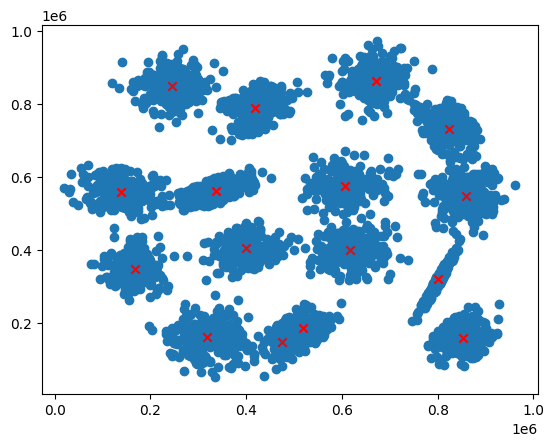

In [41]:
rdd_split_int_df_pandas = spark.createDataFrame(points_rdd_split_int, schema=["col1", "col2"]).toPandas()

cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()